# Baseline: TF-IDF + classic ML
Cel:
- wczytać dane z `data/processed/sms_spam_clean.csv`
- zrobić split train/test (stratyfikacja)
- porównać modele:
  - Logistic Regression
  - Linear SVM
- porównać wektoryzację:
  - TF-IDF word n-grams
  - TF-IDF char n-grams
- ewaluacja: precision/recall/F1 + macro F1 + confusion matrix

In [10]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

In [11]:
RANDOM_STATE = 42

REPO_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_PROCESSED = REPO_ROOT / "data" / "processed"
data_path = DATA_PROCESSED / "sms_spam_clean.csv"

assert data_path.exists(), f"Brak pliku: {data_path}. Uruchom notebook 01."
data_path

PosixPath('/Users/konrad/Documents/-ZUM_2025_KonradObrebski/data/processed/sms_spam_clean.csv')

In [12]:
df = pd.read_csv(data_path)
df.head()

,label,label_bin,text,text_clean,text_len
0,ham,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...",111
1,ham,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,29
2,spam,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,155
3,ham,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,49
4,ham,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...",61


In [13]:
X = df["text_clean"].astype(str).values
y = df["label_bin"].astype(int).values  # 1=spam, 0=ham

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train size:", len(X_train), " Test size:", len(X_test))
print("Train spam%:", y_train.mean().round(4), " Test spam%:", y_test.mean().round(4))

Train size: 4457  Test size: 1115
Train spam%: 0.1342  Test spam%: 0.1336


In [14]:
def evaluate_binary_model(name: str, model, X_test, y_test, show_cm: bool = True):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
    macro_f1 = precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)[2]

    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=["ham(0)", "spam(1)"], zero_division=0))

    if show_cm:
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=["ham", "spam"])
        

        fig, ax = plt.subplots()
        disp.plot(ax=ax, values_format="d")
        ax.set_title(f"Confusion matrix: {name}")
        plt.show()

    return {
        "model": name,
        "accuracy": acc,
        "precision_spam": prec,
        "recall_spam": rec,
        "f1_spam": f1,
        "macro_f1": macro_f1,
    }

In [15]:
experiments = []

# 1) TF-IDF word n-grams + Logistic Regression
pipe_word_lr = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
])

# 2) TF-IDF word n-grams + Linear SVM
pipe_word_svm = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
    ("clf", LinearSVC(class_weight="balanced", random_state=RANDOM_STATE))
])

# 3) TF-IDF char n-grams + Logistic Regression
pipe_char_lr = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=2, max_df=0.95)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
])

# 4) TF-IDF char n-grams + Linear SVM
pipe_char_svm = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=2, max_df=0.95)),
    ("clf", LinearSVC(class_weight="balanced", random_state=RANDOM_STATE))
])

models = [
    ("TF-IDF(word) + LogisticRegression", pipe_word_lr),
    ("TF-IDF(word) + LinearSVC", pipe_word_svm),
    ("TF-IDF(char_wb) + LogisticRegression", pipe_char_lr),
    ("TF-IDF(char_wb) + LinearSVC", pipe_char_svm),
]

len(models)

4

=== TF-IDF(word) + LogisticRegression ===
              precision    recall  f1-score   support

      ham(0)       0.99      0.99      0.99       966
     spam(1)       0.95      0.93      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



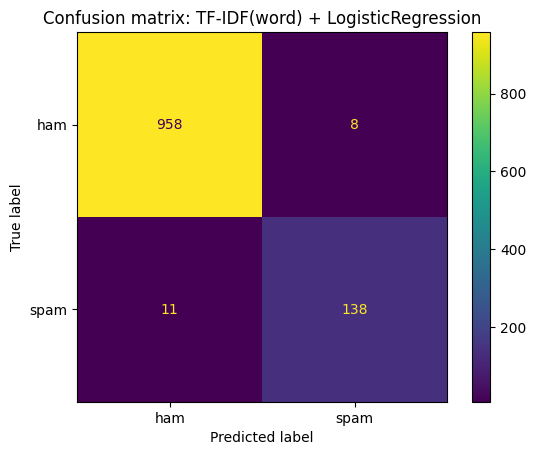

=== TF-IDF(word) + LinearSVC ===
              precision    recall  f1-score   support

      ham(0)       0.99      1.00      0.99       966
     spam(1)       0.98      0.93      0.96       149

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



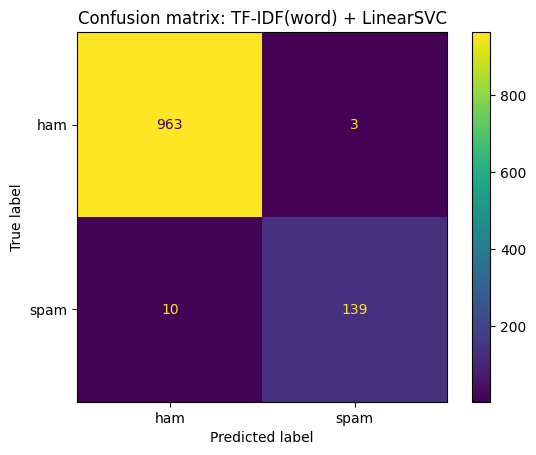

=== TF-IDF(char_wb) + LogisticRegression ===
              precision    recall  f1-score   support

      ham(0)       0.99      1.00      0.99       966
     spam(1)       0.99      0.93      0.96       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



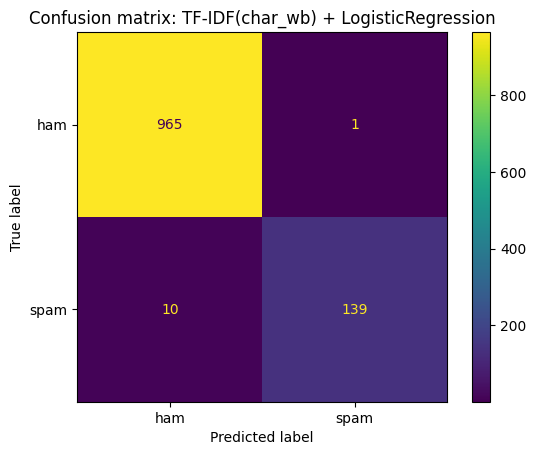

=== TF-IDF(char_wb) + LinearSVC ===
              precision    recall  f1-score   support

      ham(0)       0.99      1.00      1.00       966
     spam(1)       1.00      0.94      0.97       149

    accuracy                           0.99      1115
   macro avg       1.00      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



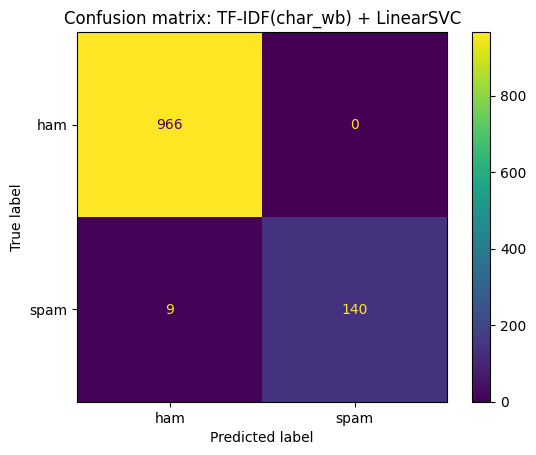

,model,accuracy,precision_spam,recall_spam,f1_spam,macro_f1
3,TF-IDF(char_wb) + LinearSVC,0.991928,1.000000,0.939597,0.968858,0.982111
2,TF-IDF(char_wb) + LogisticRegression,0.990135,0.992857,0.932886,0.961938,0.978135
1,TF-IDF(word) + LinearSVC,0.988341,0.978873,0.932886,0.955326,0.974311
0,TF-IDF(word) + LogisticRegression,0.982960,0.945205,0.926174,0.935593,0.962887


In [16]:
results = []

for name, pipe in models:
    pipe.fit(X_train, y_train)
    res = evaluate_binary_model(name, pipe, X_test, y_test, show_cm=True)
    results.append(res)

results_df = pd.DataFrame(results).sort_values(by="macro_f1", ascending=False)
results_df

In [17]:
out_results = REPO_ROOT / "reports" / "baseline_results.csv"
out_results.parent.mkdir(parents=True, exist_ok=True)

results_df.to_csv(out_results, index=False)
out_results

PosixPath('/Users/konrad/Documents/-ZUM_2025_KonradObrebski/reports/baseline_results.csv')

In [18]:
def top_features_logreg(pipeline: Pipeline, top_n: int = 20):
    vec = pipeline.named_steps["tfidf"]
    clf = pipeline.named_steps["clf"]
    if not hasattr(clf, "coef_"):
        raise ValueError("Model nie ma coef_ (użyj LogisticRegression).")

    feature_names = np.array(vec.get_feature_names_out())
    coefs = clf.coef_.ravel()

    top_pos = feature_names[np.argsort(coefs)[-top_n:]][::-1]  # spam
    top_neg = feature_names[np.argsort(coefs)[:top_n]]         # ham

    return top_pos, top_neg


pipe_word_lr.fit(X_train, y_train)
pipe_char_lr.fit(X_train, y_train)

spam_feats_word, ham_feats_word = top_features_logreg(pipe_word_lr, top_n=20)
spam_feats_char, ham_feats_char = top_features_logreg(pipe_char_lr, top_n=20)

print("=== WORD TF-IDF + LR ===")
print("Top SPAM:", spam_feats_word)
print("Top HAM :", ham_feats_word)

print("\n=== CHAR TF-IDF + LR ===")
print("Top SPAM:", spam_feats_char)
print("Top HAM :", ham_feats_char)

=== WORD TF-IDF + LR ===
Top SPAM: ['call' 'txt' 'free' 'text' 'to' 'reply' 'uk' 'stop' 'www' 'claim'
 'mobile' 'your' 'from' '150p' 'com' 'service' 'chat' 'now' 'prize' 'won']
Top HAM : ['my' 'me' 'ok' 'that' 'it' 'but' 'll' 'gt' 'lt' 'da' 'home' 'come' 'so'
 'when' 'can' 'he' 'later' 'how' 'lt gt' 'at']

=== CHAR TF-IDF + LR ===
Top SPAM: ['xt ' ' 08' 'txt' '00 ' '087' 'mob' ' 087' '50p' '150' ' txt' ' tx' '090'
 'to ' 'txt ' '150p' '.co' '871' ' 09' ' to ' ' 090']
Top HAM : [' i ' '.. ' '...' '... ' 'me ' 'my ' ' my ' ' my' " i'" ' go' ' me'
 ' me ' ' so' ' ok' ' it' 'tha' ' tha' 'that' ' that' 'at ']
